**ADZD - laboratorium nr 1**
1. Narysować wykres (pie chart) popularności sprzeglądarek.
2. Narysować wykres słupkowy liczby wywołań (request) na godzinę w zależności od czasu, pogrupowane po kodzie odpowiedzi (200, 404, etc).
3. Narysować wykres rankingu pobieranych zasobów według typów plików (html, css, png, etc.).
4. Narysować mapę z lokalizacjami klientów.
5. Oszacować jaki procent ruchu generują boty. Porównać co najmniej 2 sposoby oszacowania.

In [3]:
# Import bibliotek

import os
import regex as reg
import operator
import cartopy.crs as crs
import pandas as pd
import seaborn as sns
import requests
import json
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap

In [5]:
# Tworzymy własne środowisko
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession



spark-3.1.2-bin-hadoop3.2/
spark-3.1.2-bin-hadoop3.2/R/
spark-3.1.2-bin-hadoop3.2/R/lib/
spark-3.1.2-bin-hadoop3.2/R/lib/sparkr.zip
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/worker.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/daemon.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/shell.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/general.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.html
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.Rmd
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/index.html
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/R/
spark-3.1.2-

In [6]:
# Inicjalizacja
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
spark

In [7]:
# Pobieramy dataset

urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")

('apache_logs', <http.client.HTTPMessage at 0x7fddfa28f290>)

**Zadanie nr 1**

In [8]:
# Tworzymy RDD
data = sc.textFile("apache_logs")

# Zobaczmy, jak wyglądają nasze dane
data.collect()[:5]

['83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.149.9.216 - - [17/May/2015:10:05:43 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-dashboard3.png HTTP/1.1" 200 171717 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.149.9.216 - - [17/May/2015:10:05:47 +0000] "GET /presentations/logstash-monitorama-2013/plugin/highlight/highlight.js HTTP/1.1" 200 26185 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.

In [9]:
# Wersja biorąca wszystkie przeglądarki w logu
# browser_regex = r"(\"?\S+(?=/\d+\.\d+\s))\"?+"

browser_list = [
    'Internet Explorer',
    'Google Chrome',
    'Mozilla Firefox',
    'Safari',
    'Opera',
    'Konqueror',
    'Lynx',
    'Mozilla',
    'Chrome'
    ]

top_k = 10

def find_browser(log) -> str:
  browser_regex = r"\"(\w+(?=/\d+\.\d+))"
  result = reg.findall(browser_regex, log)
  if len(result) > 0 and result[0] in browser_list:
    return result[0]
  else:
    None

browser_counts = (data
    .map(lambda log: (find_browser(log), 1))
    .filter(lambda x: x[0] != None)
    .reduceByKey(operator.add)
    # x = (link, count)
    .takeOrdered(top_k, lambda x: x[1])
)

browser_counts

[('Lynx', 1), ('Safari', 34), ('Opera', 89), ('Mozilla', 8382)]

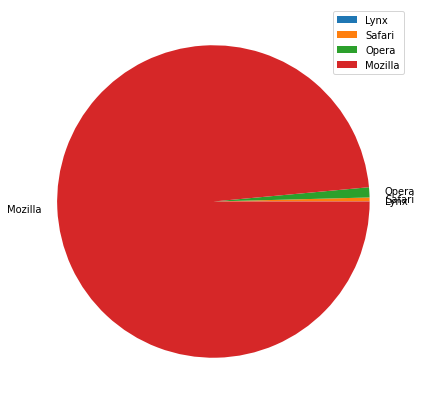

In [10]:
# Tworzymy pie chart
values = [x[1] for x in browser_counts]
browsers = [x[0] for x in browser_counts]

f = plt.figure()
f.set_figwidth(7)
f.set_figheight(10)
plt.pie(values, labels=browsers)
plt.legend()
plt.show()

**Zadanie nr 2**

In [11]:
hour_regex = "\[\d+/\w+/\d+:(\d+):"
response_code_regex = "\"(GET|HEAD|POST|OPTIONS).*?\"\s+(\d+)"
from typing import Tuple

def get_hour_and_response_code(log) -> Tuple[int, int]:
    hour = int(reg.search(hour_regex, log).group(1))
    response_code = int(reg.search(response_code_regex, log).group(2))
    return (hour, response_code)

requests_counts = (data
    .map(lambda log: (get_hour_and_response_code(log), 1))
    .reduceByKey(operator.add)
    .map(lambda x: [x[0][0], x[0][1], x[1]])
    .collect()
)

for requests_count in requests_counts[:5]:
    print(requests_count)

[10, 200, 418]
[10, 404, 11]
[11, 301, 2]
[12, 200, 418]
[12, 304, 8]


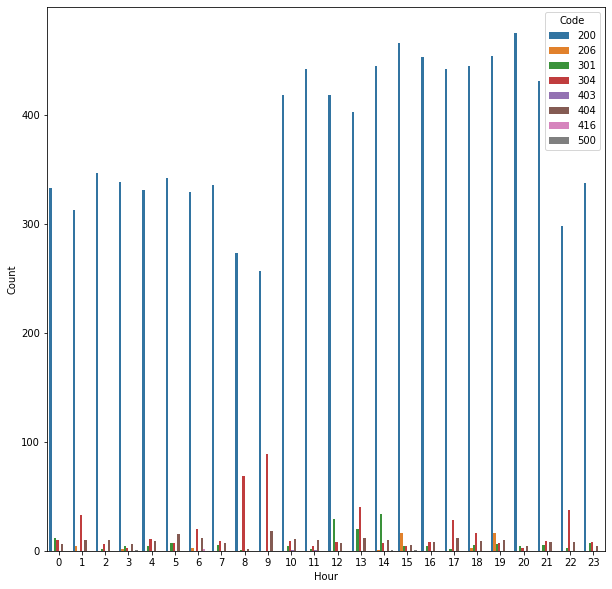

In [12]:
df = pd.DataFrame(
    data=requests_counts,
    columns=["Hour", "Code", "Count"]
)

plt.figure(figsize=[10, 10])
sns.barplot(data=df, x="Hour", y="Count", hue="Code")

**Zadanie nr 3**

In [13]:
file_type_regex = "\"GET\s+\S+\.([a-zA-Z]+) "

def get_file_type(log) -> Tuple[str, int]:

    file_type = reg.search(file_type_regex, log)
    if file_type:
      return (file_type.group(1), 1)
    else:
      return ("", 0)

resource_type_counts = (data
    .filter(lambda log: "GET" in log)
    .map(lambda log: get_file_type(log))
    .reduceByKey(operator.add)
    .filter(lambda x: x[1] != "")  
    .takeOrdered(top_k, lambda x: -x[1])
)

resource_type_counts[:10]

[('png', 2331),
 ('css', 1458),
 ('ico', 800),
 ('html', 753),
 ('jpg', 257),
 ('js', 250),
 ('txt', 192),
 ('gif', 184),
 ('xhtml', 153),
 ('jar', 90)]

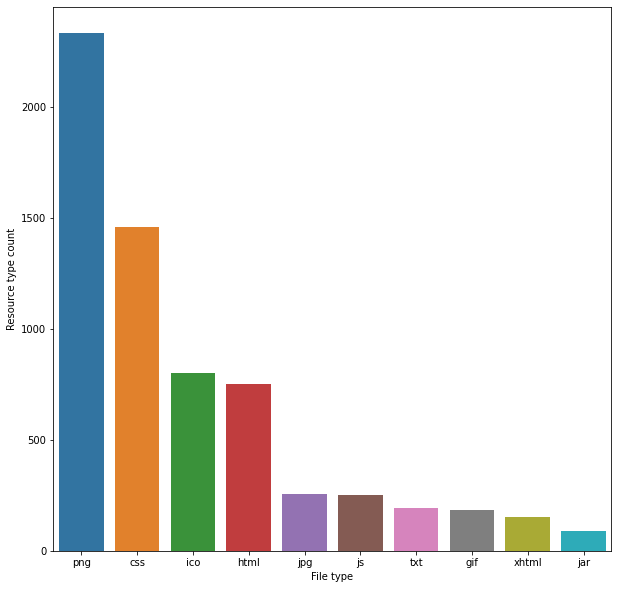

In [14]:
file_types_dict = {file_type : count for file_type, count in resource_type_counts}

df = pd.DataFrame(data = file_types_dict.values(), index=file_types_dict.keys())
df = df.reset_index()
df.columns = ["File type", "Resource type count"]

plt.figure(figsize=[10, 10])
sns.barplot(data=df, x="File type", y="Resource type count")

**Zadanie nr 4**

In [67]:
ip_regex = "[(\d\.)]+"

def get_coordinates(ip_address) -> Tuple[float, float]:

  request_url = 'https://geolocation-db.com/jsonp/' + ip_address

  response = requests.get(request_url)

  if response.status_code == 200:
    result = response.content.decode()

    result = result.split("(")[1].strip(")")
    result  = json.loads(result)
    
    return (result['latitude'], result['longitude'])
  else:
    return None

coordinates = (data
    .map(lambda log: reg.match(ip_regex, log).group(0))
    .distinct()
    .map(lambda ip: get_coordinates(ip))
    .collect()
)

coordinates[:5]

[(55.7522, 37.6156),
 (-7.5142, 109.2942),
 (48.8582, 2.3387000000000002),
 (39.9288, 116.3889),
 (15.5, -90.25)]

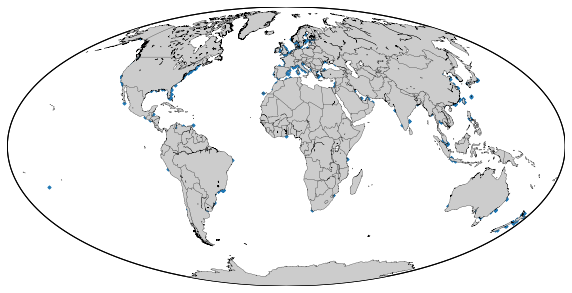

In [83]:
fig = plt.figure(figsize=(10, 12), edgecolor='w')
map = Basemap(projection='moll',lat_0=0,lon_0=0,resolution='l')
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents()
map.drawmapboundary()

lats = [lats for (lats, longs) in coordinates if type(lats) != str and lats != None]
longs = [longs for (lats, longs) in coordinates if type(longs) != str and longs != None]
map.scatter(longs, lats, latlon=True,
          cmap='Reds', marker='D',  s=5)
plt.show()

**Zadanie nr 5**

In [86]:
bots_set = {"Googlebot", "AskJeeves", "Digger", "Lycos", "msnbot",
    "Inktomi Slurp", "Yahoo", "Nutch", "bingbot", "BingPreview",
    "Mediapartners-Google", "proximic", "AhrefsBot", "AdsBot-Google",
    "Ezooms", "AddThis.com", "facebookexternalhit", "MetaURI",
    "Feedfetcher-Google", "PaperLiBot", "TweetmemeBot", "Sogou web spider",
    "GoogleProducer", "RockmeltEmbedder", "ShareThisFetcher", "YandexBot",
    "rogerbot-crawler", "ShowyouBot", "Baiduspider", "Sosospider", "Exabot"
}

bot_count = (data
    .filter(lambda log: any(bot in log for bot in bots_set))
    .count()
)

bot_perc = 100 * (bot_count / data.count())
print("Oszacowanie ruchu botów: {}%".format(round(bot_perc, 2)))

Oszacowanie ruchu botów: 13.47%
